# Objetivo de la competición

Las enzimas son proteínas que actúan como catalizadores en las reacciones químicas de los organismos vivos. El objetivo de esta competencia es predecir la termoestabilidad de las variantes enzimáticas.

## Librerias

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from itertools import chain, combinations, permutations
import sklearn.decomposition
import statsmodels.formula.api as smf
import tqdm as tq
import xgboost as xgb

In [3]:
def powerset_formulas(variables:list, response:str,left_,right_):
    """
    Genera la combinacion de formulas posibles de las variables hacia la variable respuesta
    para un modelo lm
    powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
    variables: list de str.
    response: la variable respuesta en funcion de variables.
    return: list de formulas posibles con las variables.
    """
    comb_=list(chain.from_iterable(combinations(variables, r) for r in range(left_,right_+1  )))
    formulas=[response+"~"+"+".join(list(comb_[i])) for i in range(1,len(comb_))]
    return formulas

def count_letter(df_: pd.DataFrame, column_: str, list_letter:list):
    """
    
    """
    column_len=len(list(df_))
    for letter in tq.tqdm(list_letter):
        var_temp=(df_[column_].str.count(letter)/df_["protein_length"]).copy() 
        df_ = pd.concat([df_, var_temp.rename(letter)], axis=1)
    return df_

def powerset(iterable):
    s = (iterable)
    return list(chain.from_iterable(permutations(s, r) for r in range(3)))

def count_puentes(text_:str, pos1:str,pos2:str):
    """
    
    """

    frecuencia=0
    list_texto=list(text_)
    for distancia in [4,5]:
        posicion_1 =pd.Series(list_texto[distancia:],dtype="str" )
        posicion_2= pd.Series(list_texto[:-distancia ],dtype="str")        
        frecuencia=frecuencia+ sum(((posicion_1==pos1)  & (posicion_2==pos2) ) )
    
    return frecuencia/len(text_)

def puentes_hidrogeno(df_:pd.DataFrame,column_:str,posiciones_1:str, posiciones_2:str  ):
    """
    """
    for posicion1 in posiciones_1:
        for posicion2 in posiciones_2:
            df_temp=df_[column_].apply(lambda x: count_puentes(x,posicion1,posicion2 ) ).copy()
            df_=pd.concat([df_ , df_temp.rename(posicion1+"-"+posicion2)],axis=1)
    return df_
    
list_letter=list("ARNDCEQGHILKMFPSTWYV")
list_words=["".join(list(x)) for x in powerset(list_letter)[1:]]
len(set(list_words))    



400

# Lectura de datos

En la descripción de la competencia se dan varias definciones de las base de datos que se tienen.

Como primer paso se realizara una limipeza de datos que se encuentra referencia:

https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/356251


En ella se menciona que train.csv tiene problemas de datos faltantes y que no se a modificado, donde el train_updates_20220929.csv se usa para depurar la información.


In [4]:
df_train = pd.read_csv('train.csv',index_col="seq_id")
df_train_updates = pd.read_csv("train_updates_20220929.csv",index_col="seq_id")
filtro=df_train_updates.isnull().all("columns")
all_features_nan = (df_train_updates[filtro].index)
df_train=df_train.loc[~df_train.index.isin(list(all_features_nan))  ]
swap_ph_tm_indices = df_train_updates[~filtro].index
df_train.loc[swap_ph_tm_indices , ["pH", "tm"] ]=df_train_updates.loc[swap_ph_tm_indices , ["pH", "tm"] ]
df_train=df_train.loc[~df_train["pH"].isna(), ]
X = df_train[['protein_sequence', 'pH']].copy()
Y = df_train[['tm']].copy()
X['protein_length'] = X.protein_sequence.apply(lambda x: len(x))
X = count_letter(X, "protein_sequence", list_words)
# X=puentes_hidrogeno(X, "protein_sequence", "N", "H")
# X=puentes_hidrogeno(X, "protein_sequence", "S", "S")
X['protein_length'] = np.log(X['protein_length'])
X=X.drop(labels="protein_sequence",axis=1).copy()

100%|██████████| 400/400 [00:20<00:00, 19.67it/s]


In [5]:
df_temp=X.copy()
X=X*X["pH"] 
df_temp["tm"]=Y["tm"]

cor_temp=df_temp.corr(method="spearman" )
corr_tm=cor_temp.loc["tm",]
var_=list(corr_tm[abs(corr_tm)>0.1 ].index[:-1])

In [5]:
import sklearn.feature_selection
modelo_=sklearn.feature_selection.mutual_info_regression( X , Y )
score=pd.DataFrame(modelo_)
score.index=X.columns

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [9]:
new_var=score.sort_values(0).tail(15).index
formulas=powerset_formulas(new_var, "tm", 6,10)
len(formulas)

25882

In [ ]:
df_temp=X.copy()
df_temp["tm"]=Y["tm"]
X_train, X_test, Y_train, Y_test= train_test_split(df_temp,Y,train_size=0.9,random_state=42)
list_corr_test=[]
list_corr_train=[]
for formula_ in tq.tqdm(formulas):
    modelo= smf.ols(formula_, data=X_train).fit()
    y_train_pred=modelo.predict(X_train)
    y_test_pred=modelo.predict(X_test)
    corr_test=pd.concat([Y_test,y_test_pred ] , axis=1)
    corr_test=corr_test.corr(method="spearman").iloc[0,1]
    list_corr_test.append(corr_test)
    corr_train=pd.concat([Y_train,y_train_pred ] , axis=1)
    corr_train=corr_train.corr(method="spearman").iloc[0,1]
    list_corr_train.append(corr_train)
    

 90%|████████▉ | 23182/25882 [22:09<03:41, 12.20it/s]

In [41]:
result=pd.DataFrame({"formula":formulas, "corr_train":list_corr_train, "corr_test": list_corr_test })
result["error_corr"]=abs(result["corr_train"]-result["corr_test"])
result.describe()
result[(result["error_corr"] <0.1) & (result["corr_train"]>0.2 ) ].sort_values("corr_test").tail()

,formula,corr_train,corr_test,error_corr
1816,tm~protein_length+R+P+AL+C+S+Q,0.260597,0.250486,0.010111
2587,tm~protein_length+R+P+K+AL+C+S+Q,0.269194,0.251215,0.017979
2727,tm~protein_length+P+L+K+AL+C+S+Q,0.263241,0.251297,0.011944
2773,tm~protein_length+P+K+AL+A+C+S+Q,0.265722,0.252570,0.013151
2047,tm~protein_length+P+K+AL+C+S+Q,0.265028,0.255003,0.010025


comparaciones

In [ ]:
modelo= smf.ols("", data=X_train).fit()
y_train_pred=modelo.predict(X_train)
y_test_pred=modelo.predict(X_test)
pred_train=pd.concat([Y_train,y_train_pred ] , axis=1)
pred_test=pd.concat([Y_test,y_test_pred ] , axis=1)


In [24]:
import xgboost as xgb
# Use "gpu_hist" for training the model.
reg = xgb.XGBRegressor(tree_method="gpu_hist")
# Fit the model using predictor X and response y.
reg.fit(X, Y)


In [44]:
modelo_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     tm   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     297.9
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:42:44   Log-Likelihood:            -1.0820e+05
No. Observations:               28695   AIC:                         2.165e+05
Df Residuals:                   28663   BIC:                         2.167e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         70.5699      0.624    113.011      0.000      69.346      71.794
protein_length    -0.0024      0.000    -15.170      0.000      -0.003      -0.002
A                -10.5909      2.896     -3.657      0.000     -16.268      -4.914
N                -15.0458      4.102     -3.668      0.000     -23.086      -7.005
D                -41.9491      4.127    -10.164      0.000     -50.038     -33.860
C               -103.1802      5.337    -19.335      0.000    -113.640     -92.720
Q                -92.3776      4.293    -21.517      0.000    -100.793     -83.963
G                 19.1581      2.733      7.010      0.000      13.802      24.515
K                -15.9280      3.277     -4.860      0.000     -22.351      -9.505
T               -101.5905      4.018    -25.285      0.000    -109.466     -93.715
AL               325.5066     11.396     28.563      0.000     303.169     347.844
NK                13.2653     21.005      0.632      0.528     -27.906      54.437
NF              -139.9519     26.083     -5.366      0.000    -191.075     -88.829
DQ                40.2254     24.794      1.622      0.105      -8.372      88.823
EQ              -136.5819     19.735     -6.921      0.000    -175.263     -97.900
EF              -168.6616     21.327     -7.908      0.000    -210.463    -126.860
QL              -171.1733     17.454     -9.807      0.000    -205.384    -136.963
QF              -291.4111     26.569    -10.968      0.000    -343.487    -239.335
IQ                -0.0678     21.821     -0.003      0.998     -42.839      42.703
IS              -140.0637     17.030     -8.224      0.000    -173.444    -106.683
KC               -22.6638     39.256     -0.577      0.564     -99.607      54.279
KQ              -130.8337     21.734     -6.020      0.000    -173.433     -88.235
KL              -120.1628     14.101     -8.521      0.000    -147.802     -92.523
KF               -89.4362     23.693     -3.775      0.000    -135.876     -42.997
KS              -143.4733     15.014     -9.556      0.000    -172.901    -114.046
MS              -303.3346     23.422    -12.951      0.000    -349.242    -257.427
FD              -218.9987     22.664     -9.663      0.000    -263.422    -174.576
SN              -122.1014     20.955     -5.827      0.000    -163.175     -81.028
SD               -36.0146     17.051     -2.112      0.035     -69.435      -2.594
SK              -147.5017     16.580     -8.896      0.000    -179.999    -115.004
ST               -35.1392     18.592     -1.890      0.059     -71.580       1.302
TS               -43.5991     18.841     -2.314      0.021     -80.529      -6.670
==============================================================================
Omnibus:                     3021.013   Durbin-Watson:                   1.683
Prob(Omnibus):      

In [8]:
len(list(combinations(var_, 5) ))



278256

In [6]:
list(combinations(var_, 2))

[('protein_length', 'A'),
 ('protein_length', 'R'),
 ('protein_length', 'N'),
 ('protein_length', 'D'),
 ('protein_length', 'C'),
 ('protein_length', 'Q'),
 ('protein_length', 'G'),
 ('protein_length', 'K'),
 ('protein_length', 'F'),
 ('protein_length', 'S'),
 ('protein_length', 'T'),
 ('protein_length', 'AL'),
 ('protein_length', 'RA'),
 ('protein_length', 'NE'),
 ('protein_length', 'NQ'),
 ('protein_length', 'NH'),
 ('protein_length', 'NK'),
 ('protein_length', 'NF'),
 ('protein_length', 'NS'),
 ('protein_length', 'NT'),
 ('protein_length', 'NV'),
 ('protein_length', 'DN'),
 ('protein_length', 'DC'),
 ('protein_length', 'DQ'),
 ('protein_length', 'DM'),
 ('protein_length', 'DF'),
 ('protein_length', 'DS'),
 ('protein_length', 'CD'),
 ('protein_length', 'CI'),
 ('protein_length', 'CL'),
 ('protein_length', 'CK'),
 ('protein_length', 'CF'),
 ('protein_length', 'EN'),
 ('protein_length', 'EC'),
 ('protein_length', 'EQ'),
 ('protein_length', 'EF'),
 ('protein_length', 'QN'),
 ('protein_l

In [ ]:
formulas_=powerset_formulas(var_,"tm")

In [17]:
texto=list(texto)
texto_1=pd.Series(texto[:-4])
texto_2=pd.Series(texto[4:])

In [22]:
sum((texto_1=="A") &  (texto_2=="K"))

1

<AxesSubplot:>

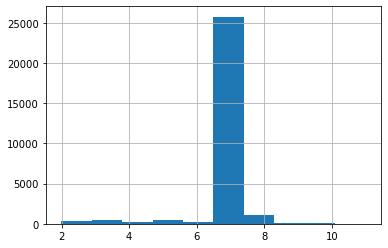

In [39]:
df_train.pH.hist()

In [ ]:

import pandas as pd
colspecs = [(0, 6), (6, 11), (12, 16), (16, 17), (17, 20), (21, 22), (22, 26),
            (26, 27), (30, 38), (38, 46), (46, 54), (54, 60), (60, 66), (76, 78),
            (78, 80)]

names = ['ATOM', 'serial', 'name', 'altloc', 'resname', 'chainid', 'resseq',
         'icode', 'x', 'y', 'z', 'occupancy', 'tempfactor', 'element', 'charge']

pdb = pd.read_fwf("wildtype_structure_prediction_af2.pdb", names=names, colspecs=colspecs)

Como resultado para el desarrollo del modelo se tiene 28,695 proteinas.